In [101]:
from statsmodels.tsa.arima_model import ARIMA

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [94]:
import csv
def write_to_file(stuff):
    csvFile = open(r'io-util.csv', 'a')
    csv_writer = csv.writer(csvFile)
    csv_writer.writerow( stuff  )
    csvFile.close()

In [63]:
def my_plotter(ax, data1, data2, param_dict, title=""):
    """
    A helper function to make a graph

    Parameters
    ----------
    ax : Axes
        The axes to draw to

    data1 : array
       The x data

    data2 : array
       The y data

    param_dict : dict
       Dictionary of kwargs to pass to ax.plot

    Returns
    -------
    out : list
        list of artists added
    """
    out = ax.plot(data1, data2, **param_dict)
    ax.figure.set_size_inches(20, 10)
    
    ax.set_title(title, fontsize=20)
    return out

In [ ]:
model_arima = ARIMA(train, order=(3, 1, 0))
model_arima_fit = model_arim.fit()
predictions = []
predictions = model_arima_fit.forecast(steps=9)[0]

In [3]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p, d, q))

In [5]:
import warnings
warnings.filterwarnings('ignore')
for param in pdq:
    try:
        model_arima = ARIMA(train, order=param
        model_arima_fit = model_arim.fit()
        print(param, model_arima_fit.aic)
    except:
        continue

In [6]:
import requests
import json

In [13]:
def run_query(prom_query):
    """
    Get the response of a simple query from prometheus
    Arguments:
        prom_query: Prometheus query
    Returns:
        JSON response of the query results
    """
    parameters = {
        "query": prom_query
    }
    QUERY_URL = 'http://127.0.0.1:9090/api/v1/query'

    try:
        r = requests.get(QUERY_URL, params=parameters)
        if r.ok:
            return json.loads(r.content)
        else:
            return -1
    except Exception as e:
        print(e)
        return -1


def run_query_range(query, start_range, end_range, step):
    """
    Query prometheus data for a specific range

    Arguments:
        query: Prometheus query
        start_range: range start time in Epoch Timestamp
        end_range: range end time in Epoch Timestamp
        step: Resolution in seconds
    Returns:

    """
    QUERY_RANGE_URL = 'http://127.0.0.1:9090/api/v1/query_range'
    parameters = {
        "query": query,
        "start": start_range,
        "end": end_range,
        "step": step
    }

    result = []

    try:
        r = requests.get(QUERY_RANGE_URL, params=parameters)
        if r.ok:
            g = json.loads(r.text)
            for each in g['data']['result']:
                for x in each['values']:
                    j = each['metric']['instance'] + ',' + ','.join(str(y) for y in x)
                    result.append(tuple(j.split(',')))
        else:
            return -1
    except Exception as e:
        print(e)
        return -1

    return result

In [14]:
Queries = {
    "mem" : "100 * (1 - ((node_memory_MemFree{job='k8s-nodes'} + node_memory_Cached{job='k8s-nodes'} + node_memory_Buffers{job='k8s-nodes'}) / node_memory_MemTotal{job='k8s-nodes'}))",
    "cpu" : "100 - (avg by (instance) (irate(node_cpu{job='k8s-nodes',mode='idle'}[2m])) * 100)",
    "io_util" : "100 * (rate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000 or irate(node_disk_io_time_ms{device='xvda', job='k8s-nodes'}[5m])/1000)"
}

In [53]:
Nodes = {
    "k8master" : "172.31.15.135:9100",
    "k8node" : "172.31.15.164:9100"
}

In [91]:
import time
end_time = int('1555662402')
hrs = 16
start_time = int(end_time - 60*60*hrs)
result = run_query_range(Queries["io_util"], start_time, end_time, 60)
hosts = {x[0] for x in result}
response = {}
for host in hosts:
    response[host] = [(int(x[1]), float(x[2])) for x in result if x[0]==host]

In [92]:
values = response[Nodes["k8master"]]

In [104]:
write_to_file(("TIME", "UTIL"))
XY = []
for x, y in values:
    XY.append((x, y))
    write_to_file( (x, y) )

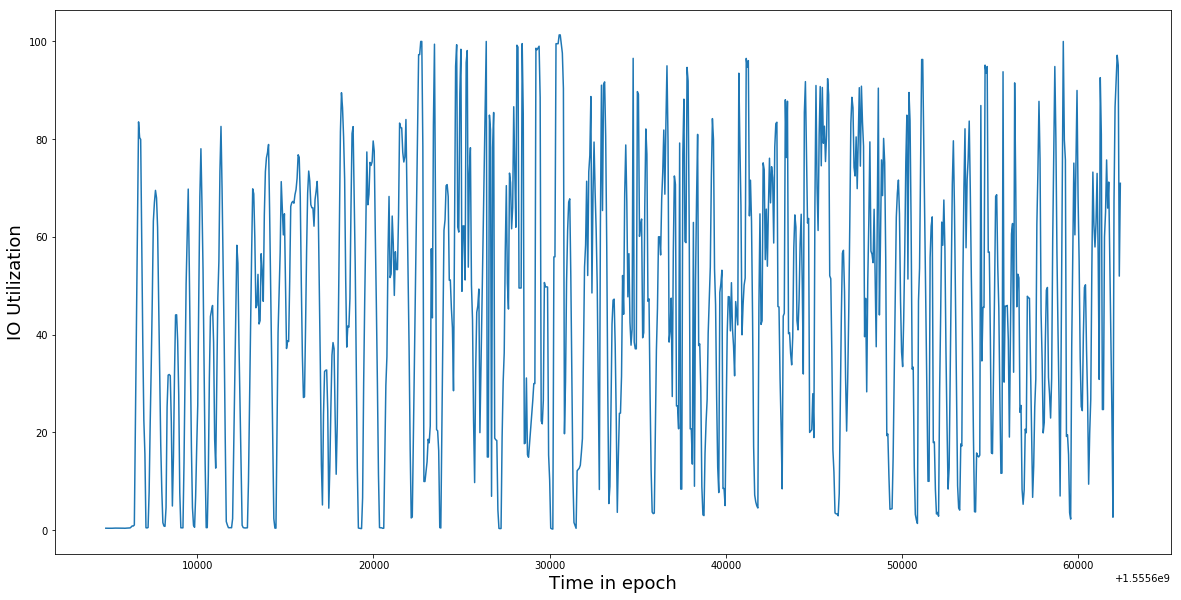

In [111]:
dataframe1 = pd.read_csv('~/Sem2/Adv Distributed Systems/project/csc724-k8s/predictor/src/io-util.csv')
x1 = dataframe1['TIME']
y1 = dataframe1['UTIL']

fig, ax = plt.subplots()

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})

In [165]:
split_percent = 96
train_samples = int(len(values)*split_percent/100)
values_train = values[0:train_samples]
values_test = values[train_samples:train_samples+10]

In [166]:
len(values_test)

10

In [173]:
Y_Train = [x[1] for x in values_train]
Y_Test = [x[1] for x in values_test]

model_arima = ARIMA(Y_Train, order=(10, 1, 0))
model_arima_fit = model_arima.fit()
predictions = []
predictions = model_arima_fit.forecast(steps=10)[0]

In [174]:
predictions

array([54.89412544, 50.55699291, 42.74201504, 45.49599934, 50.86832848,
       56.90737171, 58.03176623, 59.82107246, 62.9312489 , 62.62521221])

In [175]:
values_test

[(1555660122, 35.25585103695686),
 (1555660182, 25.306475803133),
 (1555660242, 24.46215335165047),
 (1555660302, 39.88140975036402),
 (1555660362, 49.676513928847086),
 (1555660422, 50.21756218067486),
 (1555660482, 36.992708322943145),
 (1555660542, 27.173497349243718),
 (1555660602, 9.423555186547361),
 (1555660662, 19.919574996666505)]

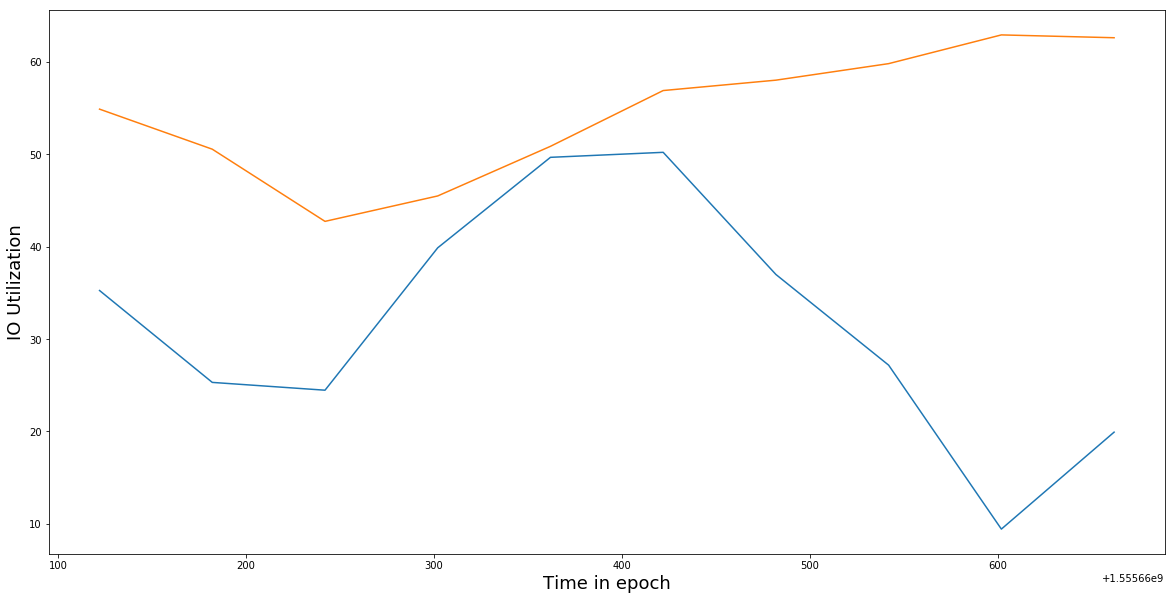

In [176]:
fig, ax = plt.subplots(1)

x1 = [x[0] for x in values_test]
y1 = [x[1] for x in values_test]

y2 = predictions

ax.set_xlabel('Time in epoch', fontsize=18)
ax.set_ylabel('IO Utilization', fontsize=18)
my_plotter(ax, x1, y1, {'marker': ''})
my_plotter(ax, x1, y2, {'marker': ''})

In [ ]:
import itertools
p=d=q=range(0,10)
pdq = list(itertools.product(p, d, q))
import warnings
warnings.filterwarnings('ignore')
aicVal = []
for param in pdq:
    try:
        model_arima = ARIMA(Y_Train, order=param)
        model_arima_fit = model_arima.fit()
        aicVal.append(param, model_arima_fit.aic)
        print(param, model_arima_fit.aic)
    except:
        continue

In [181]:
aic

[]